ECE 225 Project



In [15]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.covariance import LedoitWolf
from scipy.stats import norm

plt.style.use("seaborn-v0_8-darkgrid")

!pip install -q arch
from arch import arch_model


data_path = "/kaggle/input/s-and-p-500-stocks-trade-data-for-first-6-month-2025/sp500_2025_h1.csv"
df = pd.read_csv(data_path)

print("Shape:", df.shape)
print(df.head())

Shape: (503, 368)
     company_name ticker  02-01-2025_opening  02-01-2025_closing  \
0          Nvidia   NVDA             136.000             138.310   
1       Microsoft   MSFT             425.530             418.580   
2      Apple Inc.   AAPL             248.657             243.582   
3          Amazon   AMZN             222.030             220.220   
4  Meta Platforms   META             589.720             599.240   

   02-01-2025_volume  03-01-2025_opening  03-01-2025_closing  \
0          198247166             140.010             144.470   
1           16896469             421.080             423.350   
2           55802016             243.093             243.093   
3           33956579             222.505             224.190   
4           12682269             604.760             604.630   

   03-01-2025_volume  06-01-2025_opening  06-01-2025_closing  ...  \
0          229322478             148.590             149.430  ...   
1           16662943             428.000          

Reshape & Compute Log Returns

In [16]:
id_cols = ["company_name", "ticker"]
all_cols = df.columns.tolist()

open_cols = [c for c in all_cols if c.endswith("_opening")]
close_cols = [c for c in all_cols if c.endswith("_closing")]
volume_cols = [c for c in all_cols if c.endswith("_volume")]

print(f"# opening columns: {len(open_cols)}")
print(f"# closing columns: {len(close_cols)}")
print(f"# volume columns:  {len(volume_cols)}")

df_close = df.melt(
    id_vars = id_cols,
    value_vars = close_cols,
    var_name = "date_col",
    value_name = "close"
)
df_close["date_str"] = df_close["date_col"].str.replace("_closing", "", regex = False)
df_close = df_close.drop(columns = ["date_col"])

df_open = df.melt(
    id_vars = id_cols,
    value_vars = open_cols,
    var_name = "date_col",
    value_name = "open"
)
df_open["date_str"] = df_open["date_col"].str.replace("_opening", "", regex = False)
df_open = df_open.drop(columns = ["date_col"])

if len(volume_cols) > 0:
    df_vol = df.melt(
        id_vars = id_cols,
        value_vars = volume_cols,
        var_name = "date_col",
        value_name = "volume"
    )
    df_vol["date_str"] = df_vol["date_col"].str.replace("_volume", "", regex = False)
    df_vol = df_vol.drop(columns = ["date_col"])
else:
    df_vol = None

df_long = df_close.merge(
    df_open,
    on = id_cols + ["date_str"],
    how = "left",
    suffixes = ("_close", "_open")
)
if df_vol is not None:
    df_long = df_long.merge(
        df_vol[id_cols + ["date_str", "volume"]],
        on = id_cols + ["date_str"],
        how = "left"
    )

df_long["date"] = pd.to_datetime(df_long["date_str"], format = "%d-%m-%Y")
df_long = df_long.sort_values(["ticker", "date"])

df_long["log_return"] = df_long.groupby("ticker")["close"].transform(
    lambda x: np.log(x).diff()
)

df_long = df_long.dropna(subset = ["log_return"])

print(df_long.head())
print("Unique tickers:", df_long["ticker"].nunique())
print("Date range:", df_long["date"].min(), "→", df_long["date"].max())

# opening columns: 122
# closing columns: 122
# volume columns:  122
              company_name ticker   close    date_str     open   volume  \
753   Agilent Technologies      A  135.69  03-01-2025  133.525  1246919   
1256  Agilent Technologies      A  136.43  06-01-2025  135.340  1047034   
1759  Agilent Technologies      A  137.41  07-01-2025  135.980  1056693   
2262  Agilent Technologies      A  137.00  08-01-2025  137.220  1684573   
2765  Agilent Technologies      A  137.47  10-01-2025  135.195  1369875   

           date  log_return  
753  2025-01-03    0.016796  
1256 2025-01-06    0.005439  
1759 2025-01-07    0.007157  
2262 2025-01-08   -0.002988  
2765 2025-01-10    0.003425  
Unique tickers: 503
Date range: 2025-01-03 00:00:00 → 2025-06-30 00:00:00


Index Proxy & Basic Exploratory Plots

Sample ticker: AAPL


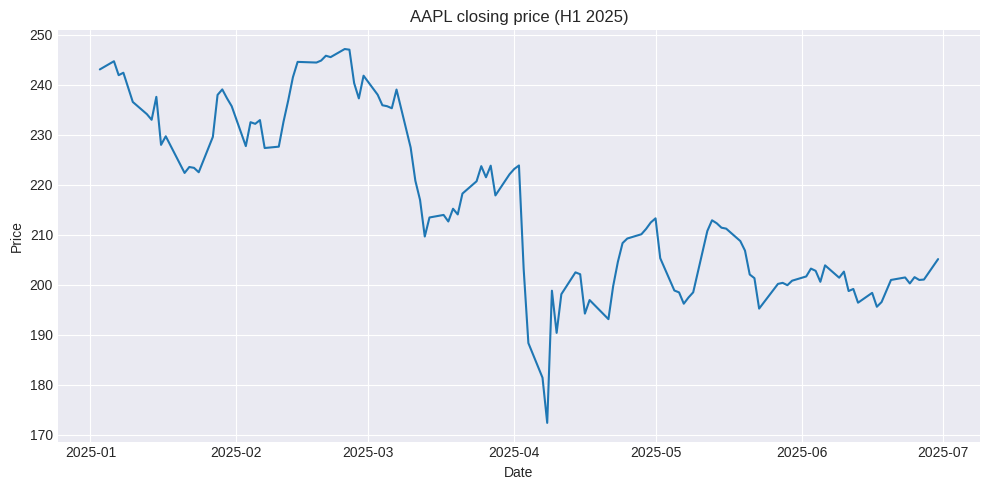

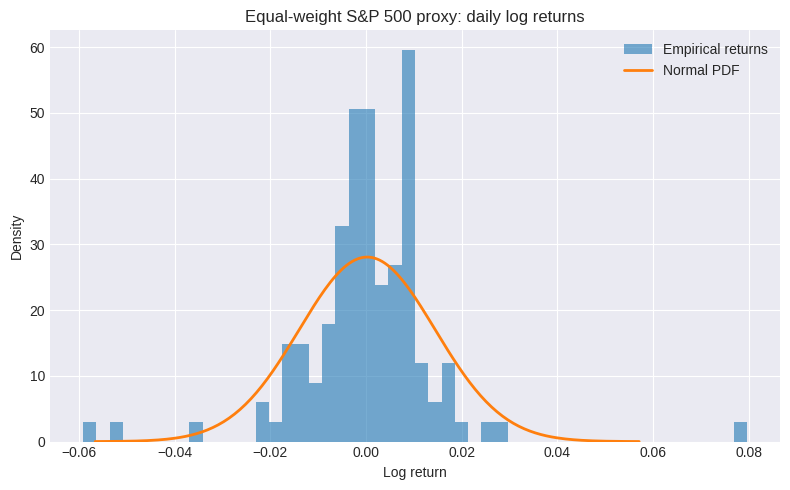

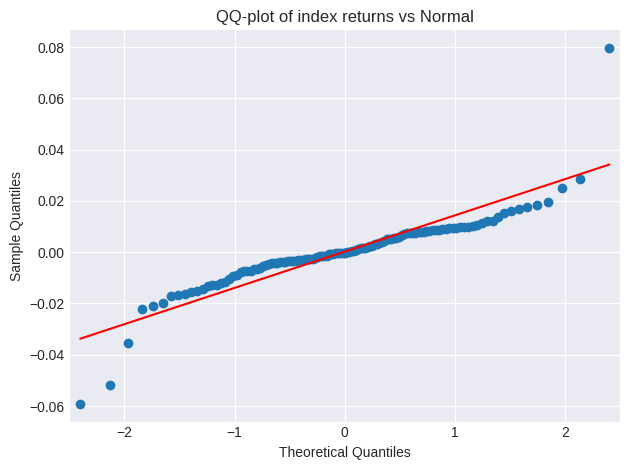

<Figure size 1000x400 with 0 Axes>

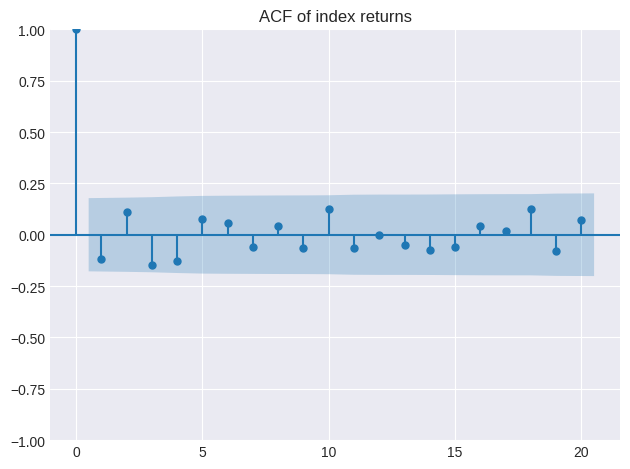

<Figure size 1000x400 with 0 Axes>

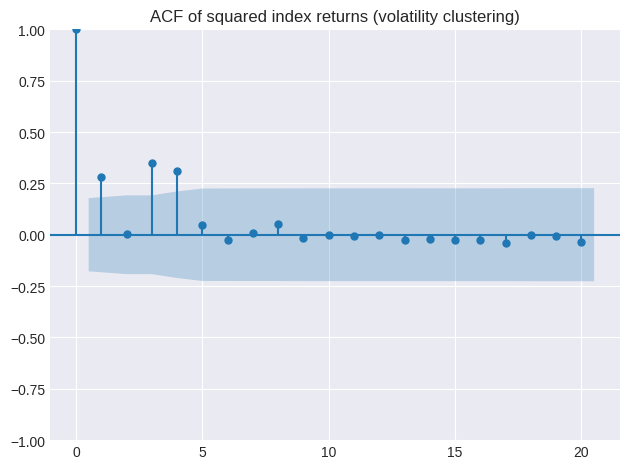

In [17]:
index_returns = (
    df_long.groupby("date")["log_return"]
    .mean()
    .sort_index()
)
index_returns.name = "sp500_eqw"

tickers = df_long["ticker"].unique()
sample_ticker = "AAPL" if "AAPL" in tickers else tickers[0]
print("Sample ticker:", sample_ticker)

sample_df = (
    df_long[df_long["ticker"] == sample_ticker]
    .sort_values("date")
    .set_index("date")
)

plt.figure(figsize = (10, 5))
plt.plot(sample_df.index, sample_df["close"])
plt.title(f"{sample_ticker} closing price (H1 2025)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

r = index_returns.dropna()
mu = r.mean()
sigma = r.std()

plt.figure(figsize = (8, 5))
plt.hist(r, bins = 50, density = True, alpha = 0.6, label = "Empirical returns")
x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 200)
plt.plot(x, norm.pdf(x, mu, sigma), lw = 2, label = "Normal PDF")
plt.title("Equal-weight S&P 500 proxy: daily log returns")
plt.xlabel("Log return")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

sm.qqplot(r, line = "s")
plt.title("QQ-plot of index returns vs Normal")
plt.tight_layout()
plt.show()

plt.figure(figsize = (10, 4))
plot_acf(r, lags = 20)
plt.title("ACF of index returns")
plt.tight_layout()
plt.show()

plt.figure(figsize = (10, 4))
plot_acf(r ** 2, lags = 20)
plt.title("ACF of squared index returns (volatility clustering)")
plt.tight_layout()
plt.show()

GARCH(1,1) Modeling & Volatility Plot

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                    sp500_eqw   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -179.855
Distribution:      Standardized Student's t   AIC:                           369.711
Method:                  Maximum Likelihood   BIC:                           383.690
                                              No. Observations:                  121
Date:                      Fri, Dec 05 2025   Df Residuals:                      120
Time:                              20:20:43   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

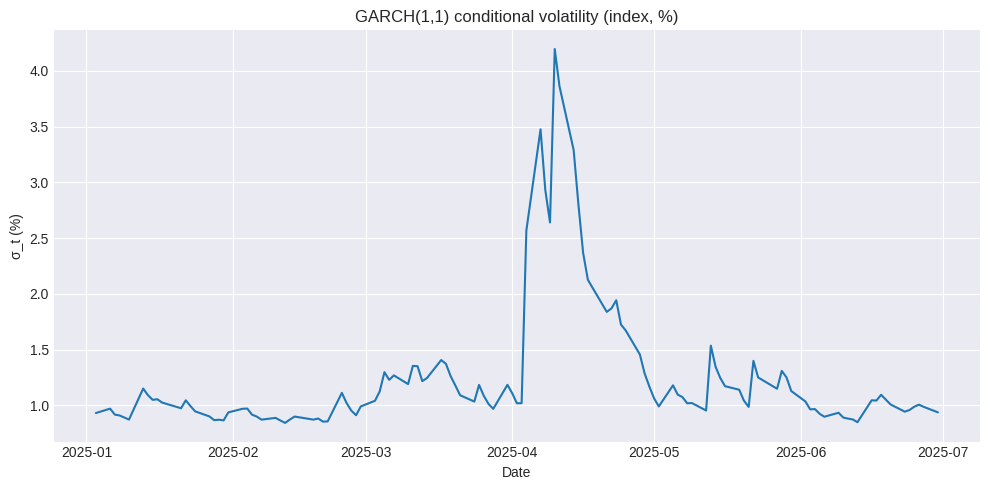

In [18]:
index_returns_pct = r * 100

am = arch_model(index_returns_pct, vol = "Garch", p = 1, q = 1, dist = "t")
res_garch = am.fit(update_freq = 5, disp = "off")

print(res_garch.summary())

cond_vol = res_garch.conditional_volatility

plt.figure(figsize = (10, 5))
plt.plot(r.index, cond_vol)
plt.title("GARCH(1,1) conditional volatility (index, %)")
plt.xlabel("Date")
plt.ylabel("σ_t (%)")
plt.tight_layout()
plt.show()

Markov Switching Model (2 Methods)

                        Markov Switching Model Results                        
Dep. Variable:                      y   No. Observations:                  121
Model:               MarkovRegression   Log Likelihood                 377.421
Date:                Fri, 05 Dec 2025   AIC                           -742.841
Time:                        20:20:44   BIC                           -726.067
Sample:                             0   HQIC                          -736.028
                                - 121                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0105      0.016     -0.656      0.512      -0.042       0.021
sigma2         0.0018      0.001      1.735      0.0

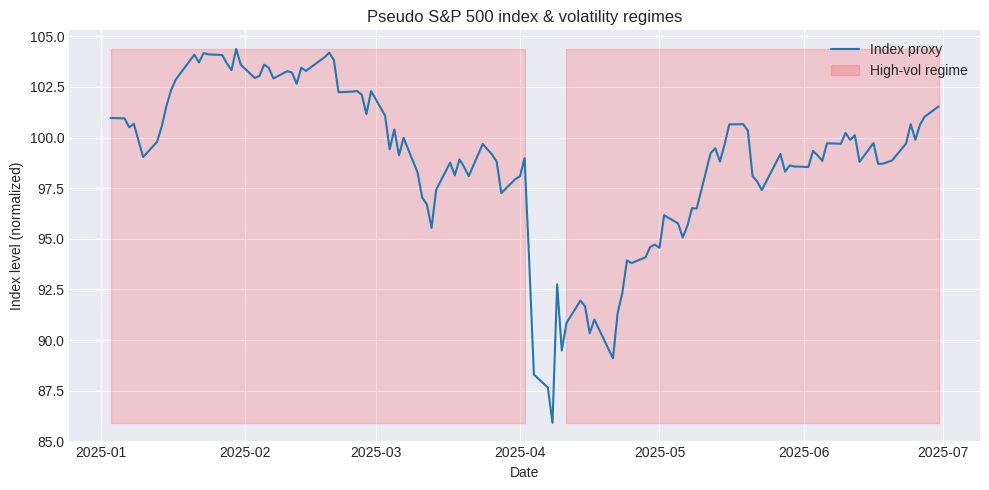

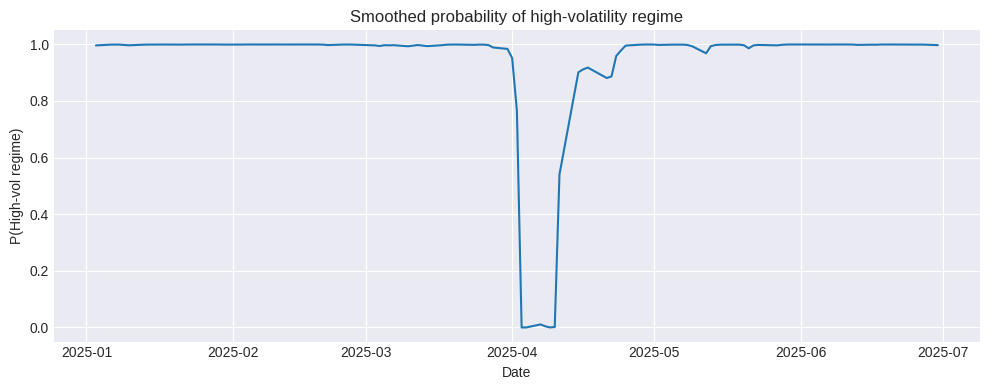

In [19]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

y = r.values

mod_ms = MarkovRegression(
    y,
    k_regimes = 2,
    trend = "c",
    switching_variance = True
)
res_ms = mod_ms.fit(em_iter = 50, search_reps = 20)
print(res_ms.summary())

smoothed_probs = res_ms.smoothed_marginal_probabilities
probs = np.asarray(smoothed_probs)
if probs.shape[0] == len(r):
    prob_high = probs[:, 1]
else:
    prob_high = probs[1, :]
regime_high = (prob_high > 0.5).astype(int)
regime_series = pd.Series(regime_high, index = r.index, name = "high_vol_regime")

index_level = (1 + r).cumprod() * 100

plt.figure(figsize = (10, 5))
plt.plot(index_level.index, index_level.values, label = "Index proxy")
high_mask = regime_series == 1
plt.fill_between(
    index_level.index,
    index_level.min(),
    index_level.max(),
    where = high_mask,
    color = "red",
    alpha = 0.15,
    label = "High-vol regime"
)
plt.title("Pseudo S&P 500 index & volatility regimes")
plt.xlabel("Date")
plt.ylabel("Index level (normalized)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize = (10, 4))
plt.plot(r.index, prob_high)
plt.title("Smoothed probability of high-volatility regime")
plt.xlabel("Date")
plt.ylabel("P(High-vol regime)")
plt.tight_layout()
plt.show()

Sector Mapping & Sector VaR/ES

Could not load sector info, using 'Unknown' for all. Error: 'sector'
Sector returns shape: (121, 1)
Sectors: ['Unknown']
Sector VaR (95%):
Unknown   -0.01714
dtype: float64

Sector ES (95%):
Unknown   -0.03236
dtype: float64


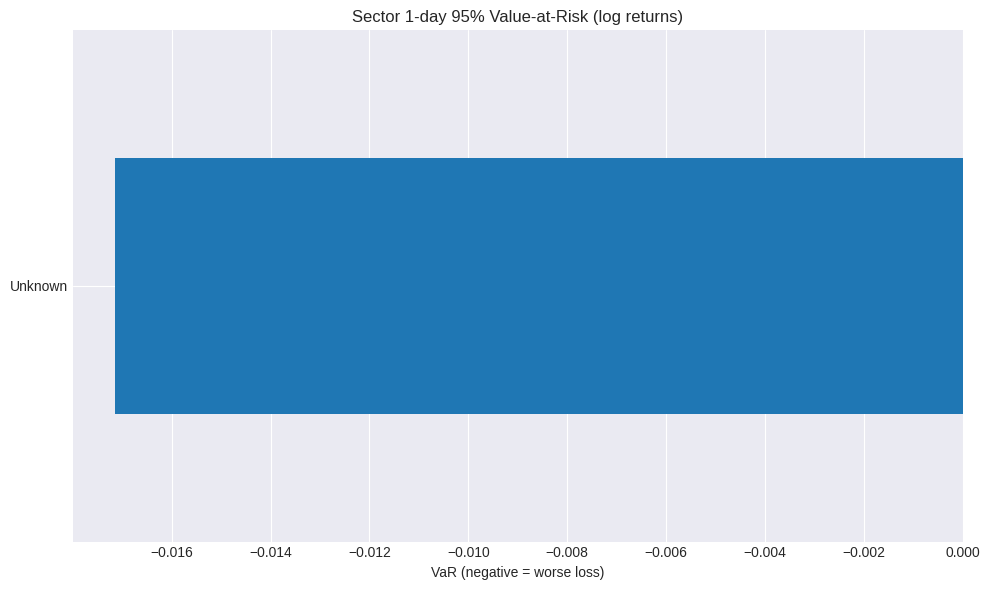

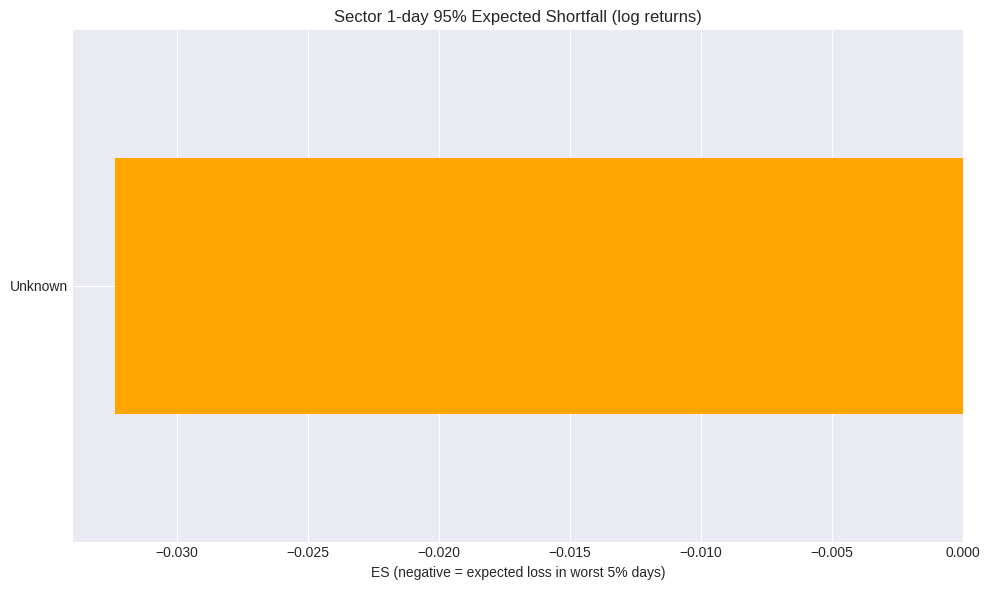


Approximate VaR breach ratios (should be ~5% for a perfect 95% VaR):
sector
Unknown    0.057851
dtype: float64


In [20]:
df_long_sect = df_long.copy()

try:
    sector_url = "https://raw.githubusercontent.com/datasets/s-and-p-500-companies/master/data/constituents.csv"
    cons = pd.read_csv(sector_url)
    cons = cons.rename(columns = {"Symbol": "ticker", "Sector": "sector"})
    sector_map = cons.set_index("ticker")["sector"]
    df_long_sect["sector"] = df_long_sect["ticker"].map(sector_map)
    print("Loaded sector info from GitHub.")
except Exception as e:
    print("Could not load sector info, using 'Unknown' for all. Error:", e)
    df_long_sect["sector"] = "Unknown"

df_long_sect = df_long_sect.dropna(subset = ["log_return"])

sector_returns = (
    df_long_sect.groupby(["date", "sector"])["log_return"]
    .mean()
    .unstack("sector")
    .sort_index()
)

print("Sector returns shape:", sector_returns.shape)
print("Sectors:", sector_returns.columns.tolist())

alpha = 0.95

def compute_var_es(series, alpha = 0.95):
    series = series.dropna()
    q = series.quantile(1 - alpha)
    es = series[series <= q].mean()
    return q, es

var_sector = {}
es_sector = {}

for sector in sector_returns.columns:
    q, es = compute_var_es(sector_returns[sector], alpha = alpha)
    var_sector[sector] = q
    es_sector[sector] = es

var_sector = pd.Series(var_sector)
es_sector = pd.Series(es_sector)

print("Sector VaR (95%):")
print(var_sector.sort_values())
print("\nSector ES (95%):")
print(es_sector.sort_values())

plt.figure(figsize = (10, 6))
var_sector.sort_values().plot(kind = "barh")
plt.title("Sector 1-day 95% Value-at-Risk (log returns)")
plt.xlabel("VaR (negative = worse loss)")
plt.tight_layout()
plt.show()

plt.figure(figsize = (10, 6))
es_sector.sort_values().plot(kind = "barh", color = "orange")
plt.title("Sector 1-day 95% Expected Shortfall (log returns)")
plt.xlabel("ES (negative = expected loss in worst 5% days)")
plt.tight_layout()
plt.show()

breach_ratios = (sector_returns.lt(var_sector)).sum() / sector_returns.notna().sum()
print("\nApproximate VaR breach ratios (should be ~5% for a perfect 95% VaR):")
print(breach_ratios.sort_values())

Portfolio Construction & Performance

Returns matrix shape: (121, 503)
Equal-weight weights sum: 0.9999999999999999
Inverse-vol weights sum: 1.0
Min-var weights sum: 1.0

=== Portfolio: EW ===
     ann_return: 0.0569
        ann_vol: 0.2256
         sharpe: 0.2523
   max_drawdown: -0.1768

=== Portfolio: IV ===
     ann_return: 0.0703
        ann_vol: 0.1995
         sharpe: 0.3523
   max_drawdown: -0.1453

=== Portfolio: MV ===
     ann_return: 0.0438
        ann_vol: 0.1871
         sharpe: 0.2342
   max_drawdown: -0.1555


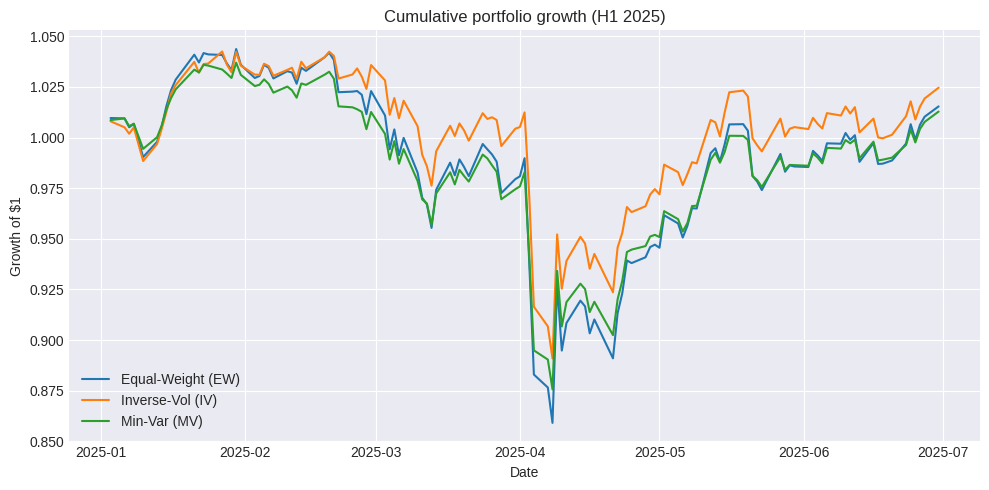

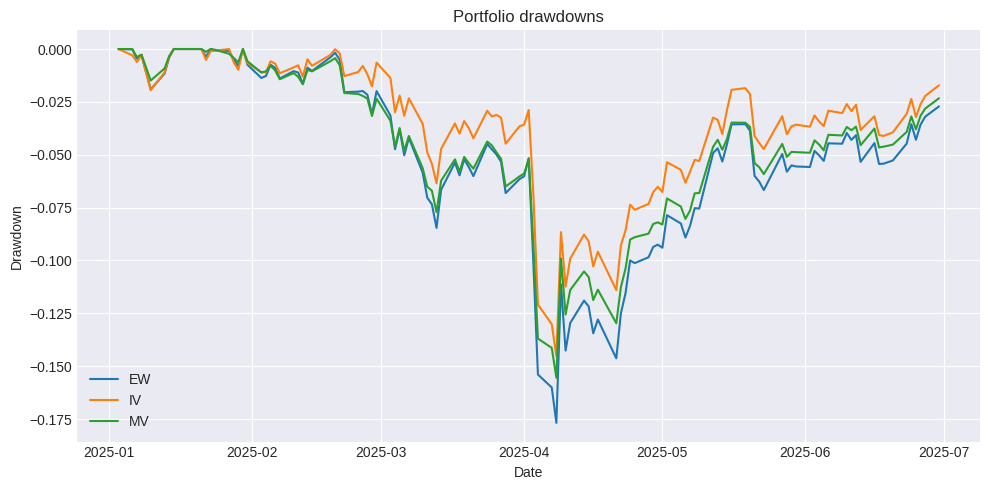


===== Low-vol regime =====
Portfolio EW: ann_return=-3.9374, ann_vol=0.8012, sharpe=-4.9142, max_dd=-0.0845
Portfolio IV: ann_return=-3.5490, ann_vol=0.6945, sharpe=-5.1098, max_dd=-0.0827
Portfolio MV: ann_return=-3.1809, ann_vol=0.6690, sharpe=-4.7544, max_dd=-0.0700

===== High-vol regime =====
Portfolio EW: ann_return=0.2653, ann_vol=0.1480, sharpe=1.7926, max_dd=-0.0846
Portfolio IV: ann_return=0.2591, ann_vol=0.1336, sharpe=1.9389, max_dd=-0.0635
Portfolio MV: ann_return=0.2121, ann_vol=0.1222, sharpe=1.7358, max_dd=-0.0772


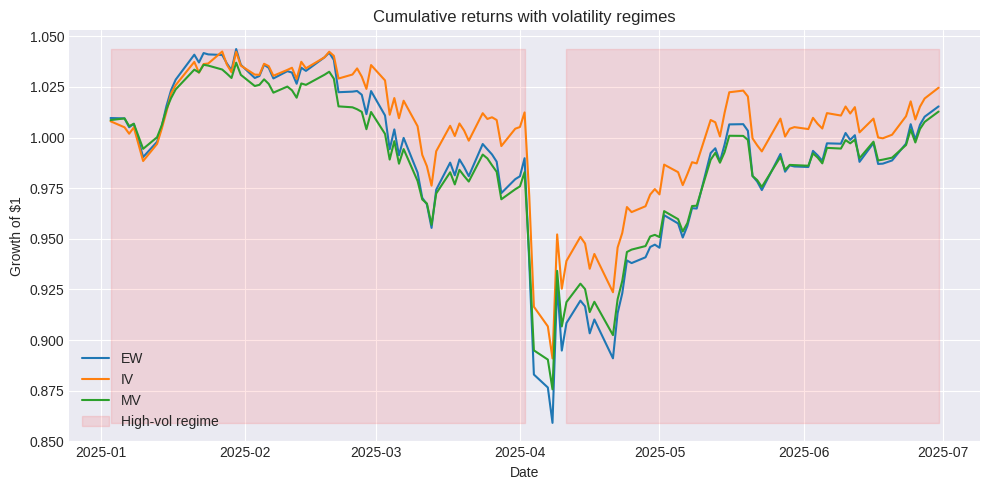

In [21]:
returns_wide = (
    df_long.pivot(index = "date", columns = "ticker", values = "log_return")
    .sort_index()
)
returns_wide = returns_wide.dropna(axis = 0, how = "any")

print("Returns matrix shape:", returns_wide.shape)

tickers_clean = returns_wide.columns
n_assets = len(tickers_clean)

w_eq = np.repeat(1.0 / n_assets, n_assets)

vols = returns_wide.std()
w_inv = 1.0 / vols
w_inv = w_inv / w_inv.sum()

lw = LedoitWolf().fit(returns_wide.values)
Sigma = lw.covariance_

ones = np.ones(n_assets)
inv_Sigma = np.linalg.inv(Sigma + 1e-6 * np.eye(n_assets))
w_mv = inv_Sigma.dot(ones)
w_mv = np.clip(w_mv, 0, None)
w_mv = w_mv / w_mv.sum()

print("Equal-weight weights sum:", w_eq.sum())
print("Inverse-vol weights sum:", w_inv.sum())
print("Min-var weights sum:", w_mv.sum())

port_eq = pd.Series(
    returns_wide.values.dot(w_eq),
    index = returns_wide.index,
    name = "EW"
)
port_inv = pd.Series(
    returns_wide.values.dot(w_inv.values),
    index = returns_wide.index,
    name = "IV"
)
port_mv = pd.Series(
    returns_wide.values.dot(w_mv),
    index = returns_wide.index,
    name = "MV"
)

def perf_stats(r):
    r = r.dropna()
    ann_ret = r.mean() * 252
    ann_vol = r.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd = cum / peak - 1
    max_dd = dd.min()
    return {
        "ann_return": ann_ret,
        "ann_vol": ann_vol,
        "sharpe": sharpe,
        "max_drawdown": max_dd
    }

for series in [port_eq, port_inv, port_mv]:
    print("\n=== Portfolio:", series.name, "===")
    stats = perf_stats(series)
    for k, v in stats.items():
        print(f"{k:>15}: {v:.4f}")

cum_eq = (1 + port_eq).cumprod()
cum_inv = (1 + port_inv).cumprod()
cum_mv = (1 + port_mv).cumprod()

plt.figure(figsize = (10, 5))
plt.plot(cum_eq.index, cum_eq, label = "Equal-Weight (EW)")
plt.plot(cum_inv.index, cum_inv, label = "Inverse-Vol (IV)")
plt.plot(cum_mv.index, cum_mv, label = "Min-Var (MV)")
plt.title("Cumulative portfolio growth (H1 2025)")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.tight_layout()
plt.show()

def drawdown_series(r):
    r = r.dropna()
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd = cum / peak - 1
    return dd

dd_eq = drawdown_series(port_eq)
dd_inv = drawdown_series(port_inv)
dd_mv = drawdown_series(port_mv)

plt.figure(figsize = (10, 5))
plt.plot(dd_eq.index, dd_eq, label = "EW")
plt.plot(dd_inv.index, dd_inv, label = "IV")
plt.plot(dd_mv.index, dd_mv, label = "MV")
plt.title("Portfolio drawdowns")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.tight_layout()
plt.show()

regime_aligned = regime_series.reindex(port_eq.index).ffill().bfill()

for lbl, name in [(0, "Low-vol regime"), (1, "High-vol regime")]:
    mask = regime_aligned == lbl
    print(f"\n===== {name} =====")
    for series in [port_eq, port_inv, port_mv]:
        stats = perf_stats(series[mask])
        print(
            f"Portfolio {series.name}: "
            f"ann_return={stats['ann_return']:.4f}, "
            f"ann_vol={stats['ann_vol']:.4f}, "
            f"sharpe={stats['sharpe']:.4f}, "
            f"max_dd={stats['max_drawdown']:.4f}"
        )

plt.figure(figsize = (10, 5))
plt.plot(cum_eq.index, cum_eq, label = "EW")
plt.plot(cum_inv.index, cum_inv, label = "IV")
plt.plot(cum_mv.index, cum_mv, label = "MV")

high_mask_port = regime_aligned == 1
plt.fill_between(
    cum_eq.index,
    min(cum_eq.min(), cum_inv.min(), cum_mv.min()),
    max(cum_eq.max(), cum_inv.max(), cum_mv.max()),
    where = high_mask_port,
    color = "red",
    alpha = 0.1,
    label = "High-vol regime"
)

plt.title("Cumulative returns with volatility regimes")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.tight_layout()
plt.show()